# Pathfinder Phase Workshop: Finding Data


**Description & purpose**: This Notebook is designed to showcase the functionality of the Earth Observation Data Hub (EODH) as the project approaches the end of the Pathfinder Phase. It provides a snapshot of the Hub, the `pyeodh` API client and the various datasets as of February 2025.

**Author(s)**: Alastair Graham, Dusan Figala

**Date created**: 2025-02-18

**Date last modified**: 2025-02-20

**Licence**: This notebook is licensed under [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/). The code is released using the [BSD-2-Clause](https://www.tldrlegal.com/license/bsd-2-clause-license-freebsd) license.

<span style="font-size:0.75em;">
Copyright (c) , All rights reserved.</span>

<span style="font-size:0.75em;">
Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:</span>

<span style="font-size:0.75em;">
Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.</span>


# Visual data discovery

# STAC Browser

The first thing to do is find some data. Initially we will be using the current Catalogue User Interface which is an implementation of the STAC Browser (**Note**: a replacement user interface is in development, as demonstrated in the Workshop). When visiting the Catalogue you should see a page not too dissimilar to the following screenshot.

![](images/07a.png "Data Catalogue")

Click on the `Search` button in the top left of the page (next to _Browse_) and start to enter some details under `search for items`. We will look for data between 12 Nov and 19 Nov 2023, in the Thetford area, in the sentinel2_ard collection. The details are shown in the next screenshot.

![](images/08a.png "Data search")

Once you click `Submit` the the search should return a series of image items to the right of the page, as shown below.

![](images/09a.png "Search result")

We are looking for the following item (S2A_20231117_latn527lone0008_T30UYD_ORB137_20231117131218_utm30n_osgb) and the reference will be as shown here:

![](images/10a.png "Item information")

Click on the relevant item to find the assets within it. There are a number of assets (data layers, metadata, thumbnail etc.) within the item. Take some time to investigate what exists. The two we are interested in here are `thumbnail` and `cog` (the cog holds the image data). The image below shows how to copy the URL to the COG data: either using the button on the left or copying the path in the text box on the right.

Check that you have found the datset we are interested in:

- Thumbnail: https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lone0008_T30UYD_ORB137_20231117131218_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_thumbnail.jpg (you can open this in a web browser and it should look like the image below)
- Dataset: https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lone0008_T30UYD_ORB137_20231117131218_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif

![](images/10.png "Item thumbnail")


Take some time to click around the listed datasets to see what is included and accessible.

**Note** that **not all collections contain accessible items**.


# Coded data discovery

There are a number of API endpoints that are exposed by the EODH. Oxidian have developed a Python API Client, `pyeodh`, that makes the Hub's API endpoints available to Python users. `pyeodh` is available on PyPi (https://pypi.org/project/pyeodh/) and can be installed using `pip`. Documentation for the API Client is available at: https://pyeodh.readthedocs.io/en/latest/api.html

We will use `pyeodh` throughout this workshop.


## Presentation set up

The following cell only needs to be run on the EODH AppHub. If you have a local Python environment running, please install the required packages as you would normally e.g. using `mamba`, `poetry` etc.


In [ ]:
# If needed you can install a package in the current AppHub Jupyter environment using pip
# For instance, we will need at least the following libraries

import sys

!{sys.executable} -m pip install --upgrade pyeodh geopandas shapely matplotlib numpy pillow folium

In [1]:
# Imports
import pyeodh

import shapely as sh
import geopandas as gpd
import folium

import urllib.request
from requests.exceptions import HTTPError

from PIL import Image
from io import BytesIO

Having imported the necessary libraries the next task is to set up the locations of the areas of interest.
Having created the AOI points the user needs to connect to the Resource Catalogue so that they can start to find some data.


In [2]:
# Areas of Interest
thet_pnt = sh.Point(0.6715892933273722, 52.414471075812315)  # a site near Thetford

In [3]:
# Optional cell
# If you want to see these points on a map run this cell
# You may need to run the notebook through a service such as nbviewer: https://nbviewer.org/

# Create a map (m) centered on the point
center_lat = thet_pnt.y
center_lon = thet_pnt.x

m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add markers for the point
folium.Marker(
    [thet_pnt.y, thet_pnt.x], popup="Thetford Site", icon=folium.Icon(color="green")
).add_to(m)

# Step 4: Display the map
m

In [4]:
# Connect to the Hub
# base_url can be changed to optionally specify a different server, such as test.eodatahub

client = pyeodh.Client(base_url="https://eodatahub.org.uk").get_catalog_service()

In [5]:
# Print a list of the collections held in the Resource Catalogue (their id and description).
# As the Resource Catalogue fills and development continues, the number of collections and the richness of their descriptions will increase

for index, collect in enumerate(client.get_collections(), start=1):
    print(f"{index} -- {collect.id}: {collect.description}")

1 -- ukcp: Regional climate model projections produced as part of the UK Climate Projection 2018 (UKCP18) project. The data produced by the Met Office Hadley Centre provides information on changes in climate for the UK until 2080, downscaled to a high resolution (12km), helping to inform adaptation to a changing climate. The projections cover Europe and a 100 year period, 1981-2080, for a high emissions scenario, RCP8.5. Each projection provides an example of climate variability in a changing climate, which is consistent across climate variables at different times and spatial locations. This dataset contains 12km data for the United Kingdom, the Isle of Man and the Channel Islands provided on the Ordnance Survey's British National Grid.
2 -- sentinel2_ard: These data have been created by the Department for Environment, Food and Rural Affairs (Defra) and Joint Nature Conservation Committee (JNCC) in order to cost-effectively provide high quality, Analysis Ready Data (ARD) for a wide ran

The dataset that we are interested in for the purposes of this workshop is `sentinel2_ard`. As seen from the output from the previous cell, we can see that the description of the dataset is as follows:

_These data have been created by the Department for Environment, Food and Rural Affairs (Defra) and Joint Nature Conservation Committee (JNCC) in order to cost-effectively provide high quality, Analysis Ready Data (ARD) for a wide range of applications. The dataset contains modified Copernicus Sentinel-2 (Level 1C data processed into a surface reflectance product using ARCSI software (Level 2))._


In [6]:
# The next thing to do is find some open data
# For this workshop we want to find Sentinel-2 analysis ready (ARD) imagery near Thetford

# First we just want to understand the timespan of the dataset which is reported from the STAC collection record
sentinel2_ard = client.get_catalog(
    "public/catalogs/ceda-stac-catalogue"
).get_collection("sentinel2_ard")
sentinel2_ard.get_items()

print(
    "DATASET TEMPORAL EXTENT: ",
    [str(d) for d in sentinel2_ard.extent.temporal.intervals[0]],
)

DATASET TEMPORAL EXTENT:  ['2022-01-02 11:35:01+00:00', 'None']


In [7]:
# Now we want to access the first few items and see what they are called, when the image was collected and how much cloud there is

lim = 10

for i, item in enumerate(sentinel2_ard.get_items()):
    if i >= lim:
        break
    print(item.id, item.properties["datetime"], item.properties["eo:cloud_cover"])

neodc.sentinel_ard.data.sentinel_2.2025.10.07.S2B_20251007_latn581lonw0081_T29VNE_ORB066_20251007171537_utm29n_osgb 2025-10-07T12:03:59Z 16.98
neodc.sentinel_ard.data.sentinel_2.2025.10.07.S2B_20251007_latn581lonw0064_T29VPE_ORB066_20251007171537_utm29n_osgb 2025-10-07T12:03:59Z 13.52
neodc.sentinel_ard.data.sentinel_2.2025.10.07.S2B_20251007_latn572lonw0081_T29VND_ORB066_20251007171537_utm29n_osgb 2025-10-07T12:03:59Z 55.04
neodc.sentinel_ard.data.sentinel_2.2025.10.07.S2C_20251007_latn536lone0009_T30UYE_ORB137_20251007130952_utm30n_osgb 2025-10-07T11:09:51Z 90.02
neodc.sentinel_ard.data.sentinel_2.2025.10.07.S2C_20251007_latn536lone0008_T31UCV_ORB137_20251007130952_utm31n_osgb 2025-10-07T11:09:51Z 90.7
neodc.sentinel_ard.data.sentinel_2.2025.10.06.S2C_20251006_latn590lonw0038_T30VVL_ORB123_20251006141242_utm30n_osgb 2025-10-06T11:44:01Z 48.01
neodc.sentinel_ard.data.sentinel_2.2025.10.06.S2C_20251006_latn590lonw0020_T30VWL_ORB123_20251006141242_utm30n_osgb 2025-10-06T11:44:01Z 21.9
n

The previous cell shows us that we are able to access Sentinel 2 ARD data and find out a number of bits of information about the item. If you are interested in seeing what other information is accessible, have a look at the

- collection endpoint: https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/ceda-stac-catalogue/collections/sentinel2_ard
- items endpoint: https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/ceda-stac-catalogue/collections/sentinel2_ard/items


In [8]:
# To find specific imagery for the Thetford site we need to add the intersects parameter. We set this to be our AOI point.

items = client.search(
    collections=["sentinel2_ard"],
    catalog_paths=["supported-datasets/catalogs/ceda-stac-catalogue"],
    intersects=thet_pnt,
    query=[
        "start_datetime>=2023-11-01",
        "end_datetime<=2023-11-30",
    ],
)

# We can then count the number of items returned by the search
# print('Number of items found: ', items.total_count)

total_items = sum(1 for _ in items)
print(f"Total items: {total_items}")


Total items: 12


In [9]:
# We can print out the item names so that we understand which images we are looking at

for item in items:
    print(f"Item ID: {item.id}")


Item ID: neodc.sentinel_ard.data.sentinel_2.2023.11.29.S2B_20231129_latn527lone0009_T31UCU_ORB094_20231129115115_utm31n_osgb
Item ID: neodc.sentinel_ard.data.sentinel_2.2023.11.29.S2B_20231129_latn527lone0008_T30UYD_ORB094_20231129115115_utm30n_osgb
Item ID: neodc.sentinel_ard.data.sentinel_2.2023.11.24.S2A_20231124_latn527lone0009_T31UCU_ORB094_20231124130018_utm31n_osgb
Item ID: neodc.sentinel_ard.data.sentinel_2.2023.11.24.S2A_20231124_latn527lone0008_T30UYD_ORB094_20231124130018_utm30n_osgb
Item ID: neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn527lone0009_T31UCU_ORB137_20231117131218_utm31n_osgb
Item ID: neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn527lone0008_T30UYD_ORB137_20231117131218_utm30n_osgb
Item ID: neodc.sentinel_ard.data.sentinel_2.2023.11.09.S2B_20231109_latn527lone0009_T31UCU_ORB094_20231109130311_utm31n_osgb
Item ID: neodc.sentinel_ard.data.sentinel_2.2023.11.09.S2B_20231109_latn527lone0008_T30UYD_ORB094_20231109130311_utm30n_osgb


Once we have found the intersecting images and know their names we can choose the image item that we are interested. For the purposes of this exercise this is T31UCU. Now we need to know what assets are held for that item. The following code prints out all the STAC information linked to that item.


In [10]:
for item in items[:1]:  # Process only the first item
    print(f"Item ID: {item.id}")
    print("Assets:")

    if not item.assets:
        print("  No assets available.")
    else:
        for asset_key, asset in item.assets.items():
            print(
                f"  - {asset_key}: {asset.to_dict()}"
            )  # Convert asset to dict for readable output
            print("-" * 40)  # Separator for better readability

Item ID: neodc.sentinel_ard.data.sentinel_2.2023.11.29.S2B_20231129_latn527lone0009_T31UCU_ORB094_20231129115115_utm31n_osgb
Assets:
  - cloud: {'href': 'https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/29/S2B_20231129_latn527lone0009_T31UCU_ORB094_20231129115115_utm31n_osgb_clouds.tif', 'type': 'image/tiff; application=geotiff', 'size': 4718566, 'location': 'on_disk', 'roles': ['data']}
----------------------------------------
  - cloud_probability: {'href': 'https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/29/S2B_20231129_latn527lone0009_T31UCU_ORB094_20231129115115_utm31n_osgb_clouds_prob.tif', 'type': 'image/tiff; application=geotiff', 'size': 85706492, 'location': 'on_disk', 'roles': ['data']}
----------------------------------------
  - cog: {'href': 'https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/29/S2B_20231129_latn527lone0009_T31UCU_ORB094_20231129115115_utm31n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif', 'type': 'image/tiff; a

From this we can see that there is a thumbnail. Before we do anything with the full image data or associated assets it would be good to understand the image. We can extract the URL to the thumbnail and view the attached image file.


In [11]:
tn_url = None

for item in items[:1]:  # Process only the first item
    # print(f"Item ID: {item.id}")
    # print("Assets:")

    if not item.assets:
        print("  No assets available.")
    else:
        for asset_key, asset in item.assets.items():
            # print(f"  - {asset_key}: {asset.to_dict()}")  # Convert asset to dict for readable output
            if asset_key == "thumbnail":
                tn_url = asset.href  # Directly access the href attribute

    # print("-" * 40)  # Separator for better readability
print(tn_url)

https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/29/S2B_20231129_latn527lone0009_T31UCU_ORB094_20231129115115_utm31n_osgb_vmsk_sharp_rad_srefdem_stdsref_thumbnail.jpg


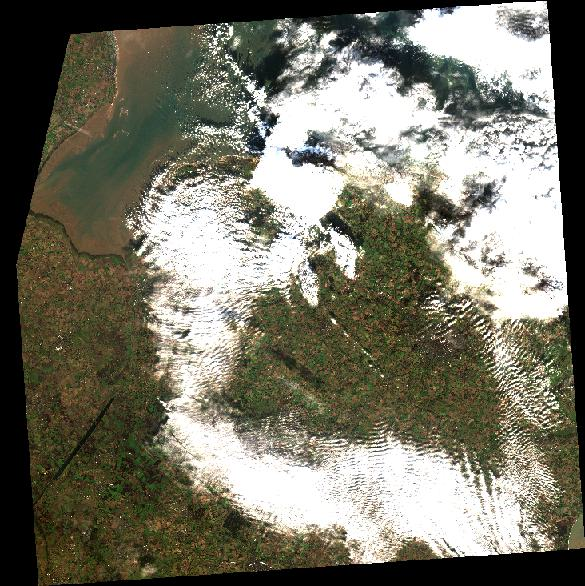

In [12]:
# We can use this information to view the image thumbnail

# Here we open the remote URL, read the data and dislay the thumbnail
with urllib.request.urlopen(tn_url) as url:
    img = Image.open(BytesIO(url.read()))

display(img)

This shows that we can relatively easily interrogate the Resource Catalogue and filter the results so that we can find the data we require in the EODH. With a bit of tweaking of the code the user could also generate a list of assets and accompanying URLs to the datasets (for this and other datasets).


Now we want to see what commercial data exists.


In [13]:
# Find some Airbus commercial data: SPOT

count = 0
lim = 15

for i in client.search(
    catalog_paths=["supported-datasets/catalogs/airbus"],
    collections=["airbus_spot_data"],
):
    if count >= lim:
        break
    print(i.id)
    count += 1


DS_SPOT6_202510100052129_JS3_JS3_JS1_JS1_E140N32_01140
DS_SPOT6_202510100052025_JS3_JS3_JS1_JS1_E140N33_01140
DS_SPOT6_202510092332109_FR1_FR1_SV1_SV1_E149S37_04794
DS_SPOT6_202510092331525_FR1_FR1_SV1_SV1_E150S36_01871
DS_SPOT6_202510092331204_FR1_FR1_SV1_SV1_E150S36_04469
DS_SPOT6_202510092331059_FR1_FR1_SV1_SV1_E150S35_01709
DS_SPOT6_202510092330151_FR1_FR1_SV1_SV1_E152S31_06418
DS_SPOT6_202510092329595_FR1_FR1_SV1_SV1_E152S29_01871
DS_SPOT6_202510092329302_FR1_FR1_SV1_SV1_E152S28_04794
DS_SPOT6_202510092329141_FR1_FR1_SV1_SV1_E152S27_01790
DS_SPOT6_202510092328582_FR1_FR1_SV1_SV1_E152S25_01790
DS_SPOT6_202510092328197_FR1_FR1_SV1_SV1_E153S25_05443
DS_SPOT6_202510092320377_FR1_FR1_SV1_SV1_E163N05_01140
DS_SPOT6_202510092128406_FR1_FR1_FR1_FR1_W162N55_01627
DS_SPOT6_202510092128245_FR1_FR1_FR1_FR1_W162N55_01790


In [15]:
# Find some Planet commercial data: Planetscope Scene
count = 0
try:
    cat = client.get_catalog("commercial/catalogs/planet")
    for i in cat.search(collections=["PSScene"]):
        if count >= lim:
            break
        print(i.id)
        count += 1
except HTTPError as e:
    if "422 Client Error: Unprocessable Entity" in str(e):
        print("Skipping E422")
    else:
        raise  # Re-raise other errors

20251010_115847_53_24b8
20251010_092850_38_2513
20251010_083312_32_2514
20251010_083117_93_2514
20251010_053234_02_2541
20251010_092334_99_2513
20251010_053711_61_2541
20251010_083806_11_24f0
20251010_083034_76_2514
20251010_052928_99_24aa
Skipping E422


The final step would be to use the ordering service integrated into the EODH resource catalogue to purchase the required commercial imagery. This would be stored in a users workspace and could then be used in specific workflows or for data analytics (depending on licence restrictions).

For the purposes of this workshop we looked at the different commercial datasets offline in QGIS.
